# Amazon SageMaker Object Detection

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Shuffle and Split Manifest](#Shuffle-and-Split-Manifest)
  2. [Create Channels](#Create-Channels)
4. [Training](#Initial-Training)
6. [Hosting](#Hosting)
7. [Inference](#Inference)
8. [Preparation for AWS DeepLens](#Preparation-for-AWS-DeepLens)
  1. [Deploy](#Deploy)

## Introduction

In this example, I will show you how to train an object detector using an augmented manifest generated by a GroundTruth Labeling Job.

Then, I will deploy and test the model with a SageMaker Endpoint, and prepare the model for deploying it to DeepLens.

## Setup

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [72]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::881825932265:role/service-role/AmazonSageMaker-ExecutionRole-20220722T134737
CPU times: user 193 ms, sys: 8.82 ms, total: 202 ms
Wall time: 265 ms


We also need the S3 bucket that you want to use for training and to store the trained model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

In [73]:
bucket = 'objectdetect-demo2-output'

manifest_key = 'detect-demo3/manifests/output/output.manifest' #e.g.: 'labeled/nfingers/manifests/output/output.manifest'

s3_artifact_location = 's3://{}/output'.format(bucket)

training_manifest_key = 'detect-demo3/manifests/output/training_manifest.json'
validation_manifest_key = 'detect-demo3/manifests/output/validation_manifest.json'

Lastly, we need the Amazon SageMaker Object Detection docker image, which is static and need not be changed.

In [74]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


## Data Preparation
The current manifest file includes all the data that was labeled by the Labeling Job in GroundTruth. In order to pass it through the algorithm, we need to shuffle it and split it into training and validation data sets. These data sets are then passed to the SageMaker Estimator as channels.

### Shuffle and Split manifest

In [75]:
%%time
import json
from sklearn.model_selection import train_test_split
import numpy as np
import os
import boto3

s3 = boto3.resource('s3')

manifest = s3.Object(bucket, manifest_key)
items = manifest.get()['Body'].read().decode('utf-8').split('\n')

training_filename = 'training.manifest'
validation_filename = 'validation.manifest'

data = np.array(items)
# Before splitting, it's good to shuffle the entire dataset.

np.random.shuffle(data)
training_set, validation_set = train_test_split(data, test_size=0.1)

with open(training_filename, mode='w') as manifest:
    for item in training_set:
        if item:
            manifest.write(item + os.linesep)
    
with open(validation_filename, mode='w') as manifest:
    for item in validation_set:
        if item:
            manifest.write(item + os.linesep)
        
training_manifest = s3.Object(bucket, training_manifest_key)
training_manifest.upload_file(training_filename)

validation_manifest = s3.Object(bucket, validation_manifest_key)
validation_manifest.upload_file(validation_filename)

CPU times: user 32.6 ms, sys: 6.64 ms, total: 39.2 ms
Wall time: 313 ms


### Create channels
Let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [76]:
def get_object_uri(obj):
    return 's3://{}/{}'.format(obj.bucket_name, obj.key)

# Create a train and validation data channel with S3_data_type as 'AugmentedManifestFile' and attribute names.
training_data = sagemaker.session.s3_input(
                                        get_object_uri(training_manifest),
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'wolf'],
                                        record_wrapping='RecordIO') 

validation_data = sagemaker.session.s3_input(
                                        get_object_uri(validation_manifest),
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'wolf'],
                                        record_wrapping='RecordIO')

data_channels = {'train': training_data, 'validation': validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [841]:
s3_output_location = 's3://{}/model/output'.format(bucket)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a `sagemaker.estimator.Estimator` object. This estimator will launch the training job.

In [842]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm.

In [843]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=3,
                             mini_batch_size=4,
                             epochs=50,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='rmsprop',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=100,
                             num_training_samples=len(training_set))

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, thanks to using `Pipe` mode, the data from our channels is streamed into the instance and the training begins immediately after the training image is downloaded to the instance and we'll start getting logs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm.

Once the job has finished a "Training job completed" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [844]:
od_model.fit(inputs=data_channels, logs=True)

2022-08-11 06:42:27 Starting - Starting the training job...
2022-08-11 06:42:52 Starting - Preparing the instances for trainingProfilerReport-1660200146: InProgress
.........
2022-08-11 06:44:22 Downloading - Downloading input data
2022-08-11 06:44:22 Training - Downloading the training image............
2022-08-11 06:46:18 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/11/2022 06:46:23 INFO 140052014032704] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_samples': '', 'image_shape': '3

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge``. The endpoint deployment can be accomplished as follows:

In [845]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-----------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us get some random image from the validation data set.

37


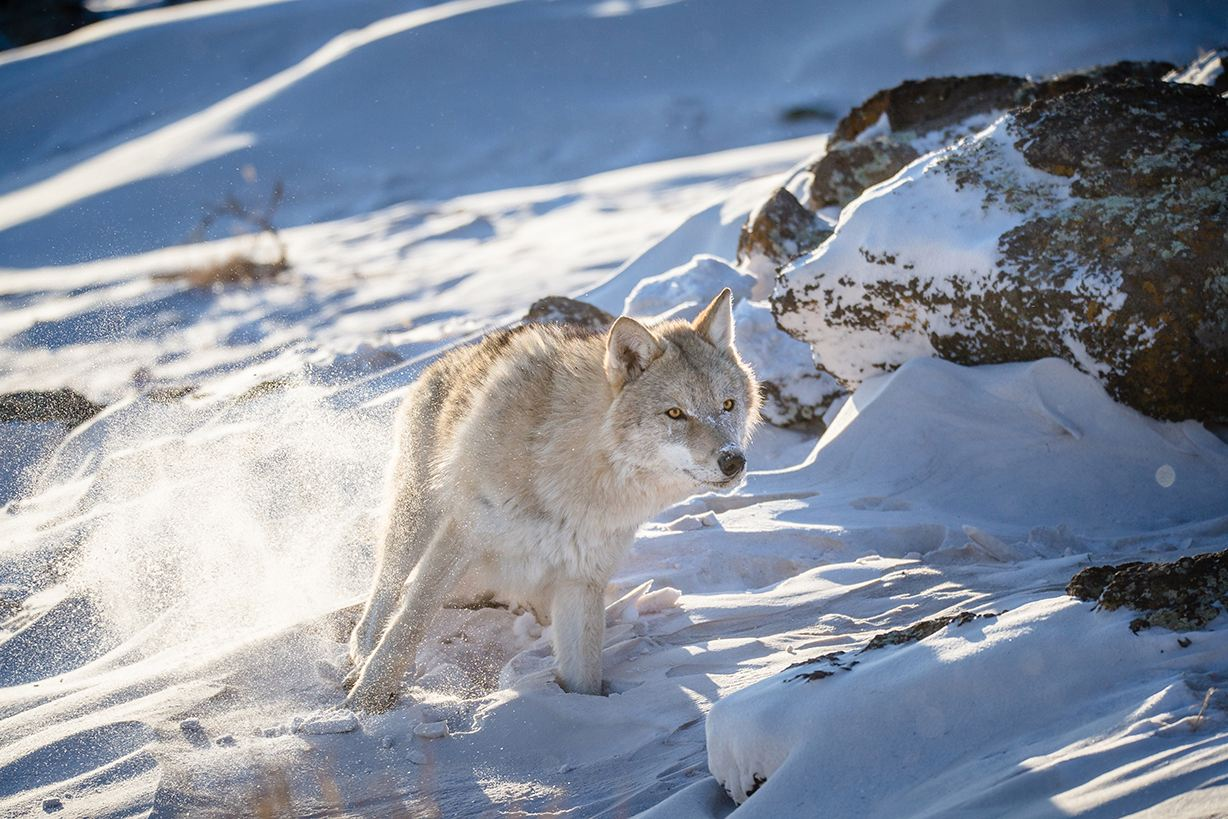

In [915]:
import random
import json

print(object_detector)
# pic a random image from the validation set
val_image_index = random.randint(0, len(validation_set)-1)
print(val_image_index)
test_img_uri = json.loads(validation_set[val_image_index])['source-ref']

l = test_img_uri[5:].split('/')
bucket = l[0]
key = '/'.join(l[1:])

#zhangry 自定义
#bucket = 'demobucket-obdetect-01'
#key = '3a52bd74b55c0ee464925e0d7cbb6ee5.jpeg'

obj = s3.Object(bucket_name=bucket, key=key)
file_name = '/tmp/test.jpg'

with open(file_name, 'wb') as data:
    obj.download_fileobj(data)
    
# test image
from IPython.display import Image
Image(file_name)

In [916]:
#object_detector.content_type = 'image/jpeg'
#object_detector.predict(initial_args={'ContentType': 'image/jpeg'})
results = object_detector.predict(obj.get()['Body'].read(), initial_args={'ContentType': 'image/jpeg'})
detections = json.loads(results)
print (detections)

{'prediction': [[0.0, 0.34410205483436584, 0.49992847442626953, 0.40535497665405273, 0.6130785942077637, 0.6015379428863525], [2.0, 0.11320760101079941, 0.4922868013381958, 0.4334179162979126, 0.6136555671691895, 0.6063134670257568], [2.0, 0.1005866602063179, 0.6230654716491699, 0.6832480430603027, 0.7071702480316162, 0.7427537441253662], [2.0, 0.09994730353355408, 0.6801093816757202, 0.39587002992630005, 0.7414149045944214, 0.495299756526947], [2.0, 0.08871638774871826, 0.0, 0.9025177955627441, 0.09986880421638489, 1.0], [2.0, 0.08816780894994736, 0.6273194551467896, 0.7905600070953369, 0.706315279006958, 0.8456284999847412], [2.0, 0.08478390425443649, 0.04016973450779915, 0.0, 0.13899052143096924, 0.05363842099905014], [2.0, 0.08436184376478195, 0.6712946891784668, 0.15508270263671875, 0.7628390789031982, 0.22088125348091125], [2.0, 0.08300033211708069, 0.4715206027030945, 0.36921244859695435, 0.5517213940620422, 0.43127745389938354], [2.0, 0.08299705386161804, 0.0, 0.416986525058746

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visualize the high-confidence predictions with bounding box by filtering out low-confidence detections using the script below:

In [917]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

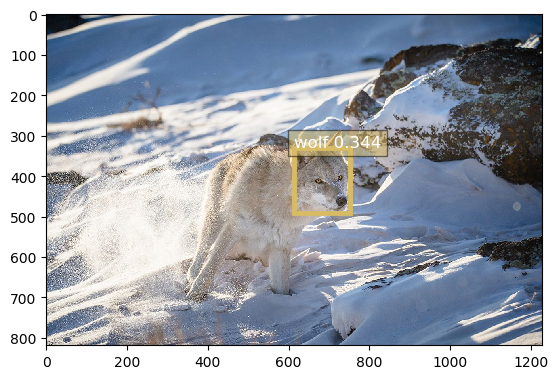

In [918]:
object_categories = ['wolf', 'dog', 'sheep']

# Setting a threshold 0.50 will only plot detection results that have a confidence score greater than 0.50.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

# Preparation for AWS DeepLens
DeepLens requires some previous manipulation of the model in order to work. For this we need the model artifact and the MXNet deploy script.

In [ ]:
# Download the model artifact
!aws s3 cp '{od_model.model_data}' .

In [ ]:
# Extract the contents and rename it for the deployment script
!mkdir -p model
!tar -xvzf model.tar.gz --directory model --overwrite
!mv model/model_algo_1-0000.params model/ssd_resnet50_300-0000.params
!mv model/model_algo_1-symbol.json model/ssd_resnet50_300-symbol.json

In [ ]:
# Download the script from GitHub
!git clone https://github.com/apache/incubator-mxnet

In [ ]:
# Run the script with the right parameters
!python incubator-mxnet/example/ssd/deploy.py --network resnet50 --num-class 3

In [ ]:
# Zip the deployable model and copy it to the DeepLens bucket
!tar -cvzf patched_model.tar.gz -C model \
./deploy_ssd_resnet50_300-0000.params \
./deploy_ssd_resnet50_300-symbol.json \
./hyperparams.json

In [ ]:
# Copy the patched model to the DeepLens bucket
deeplens_bucket = '<your-deeplens-bucket-for-models>'
!aws s3 cp patched_model.tar.gz s3://{deeplens_bucket}/models/

# Deploy

Go to the DeepLens Console and create a project, import an external model using the S3 Uri for the patched_model.tar.gz, then deploy it to the device.

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)